In [65]:
import numpy as np
import pandas as pd
import tempfile
temp_dir = tempfile.TemporaryDirectory()
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import *
from pandas.tseries.offsets import MonthEnd

from sklearn.model_selection import RandomizedSearchCV
import time

from __future__ import division
from scipy.stats import pearsonr

import mlflow
import mlflow.sklearn

Récupération du dataset original home_data

In [66]:
# import Data
# https://raw.githubusercontent.com/rashida048/Datasets/master/home_data.csv

raw_data = pd.read_csv('https://raw.githubusercontent.com/rashida048/Datasets/master/home_data.csv')

# on convertit en datetime notre colonne de date
raw_data["date"] = pd.to_datetime(raw_data["date"])
raw_data

id       date   price  bedrooms  bathrooms  sqft_living  \
0      7129300520 2014-10-13  221900         3       1.00         1180   
1      6414100192 2014-12-09  538000         3       2.25         2570   
2      5631500400 2015-02-25  180000         2       1.00          770   
3      2487200875 2014-12-09  604000         4       3.00         1960   
4      1954400510 2015-02-18  510000         3       2.00         1680   
...           ...        ...     ...       ...        ...          ...   
21608   263000018 2014-05-21  360000         3       2.50         1530   
21609  6600060120 2015-02-23  400000         4       2.50         2310   
21610  1523300141 2014-06-23  402101         2       0.75         1020   
21611   291310100 2015-01-16  400000         3       2.50         1600   
21612  1523300157 2014-10-15  325000         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
0          5650     1.0           0     0  ...      7        1180   
1          7242     2.0           0     0  ...      7        2170   
2         10000     1.0           0     0  ...      6         770   
3          5000     1.0           0     0  ...      7        1050   
4          8080     1.0           0     0  ...      8        1680   
...         ...     ...         ...   ...  ...    ...         ...   
21608      1131     3.0           0     0  ...      8        1530   
21609      5813     2.0           0     0  ...      8        2310   
21610      1350     2.0           0     0  ...      7        1020   
21611      2388     2.0           0     0  ...      8        1600   
21612      1076     2.0           0     0  ...      7        1020   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0                  0      1955             0    98178  47.5112 -122.257   
1                400      1951          1991    98125  47.7210 -122.319   
2                  0      1933             0    98028  47.7379 -122.233   
3                910      1965             0    98136  47.5208 -122.393   
4                  0      1987             0    98074  47.6168 -122.045   
...              ...       ...           ...      ...      ...      ...   
21608              0      2009             0    98103  47.6993 -122.346   
21609              0      2014             0    98146  47.5107 -122.362   
21610              0      2009             0    98144  47.5944 -122.299   
21611              0      2004             0    98027  47.5345 -122.069   
21612              0      2008             0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               1690        7639  
2               2720        8062  
3               1360        5000  
4               1800        7503  
...              ...         ...  
21608           1530        1509  
21609           1830        7200  
21610           1020        2007  
21611           1410        1287  
21612           1020        1357  

[21613 rows x 21 columns]

In [67]:
# fonction pour évaluer nos prédictions

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

-14.148465407275422 10946782.37700646


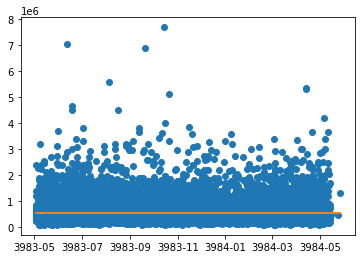

In [68]:
# on trace la régréssion linéaire entre le prix et la date (ordinale)
(a,b)=np.polyfit(raw_data["date"].map(dt.datetime.toordinal),raw_data['price'],1)

# on affiche nos coefficients de regression
print(a,b)

plt.plot_date(raw_data["date"].map(dt.datetime.toordinal), raw_data['price'], fmt='o', tz=None, xdate=True, ydate=False)
plt.plot(raw_data["date"].map(dt.datetime.toordinal),raw_data["date"].map(dt.datetime.toordinal)*a+b)

Traitement des données et ajustement des prix avec augmentation linéaire

In [69]:
# on définit un nouveau df, une date = un coefficient d'ajustement de prix
df_transfo = raw_data[["date"]].drop_duplicates().sort_values('date').reset_index().drop(['index'],axis=1)

# transformation prix final : 1.03 soit 103% 
# création d'un vecteur pour chaque date, avec transformation linéaire de +5%
coef_augmentation_final = 1.15
vect_ajust = [ float(x) for x in np.linspace(start = 1, stop = coef_augmentation_final, num = df_transfo["date"].count())]

# ajout colonne au dataFrame transfo
df_transfo["coef_ajustement"] = vect_ajust
df_transfo

# merge sur les dates du dataset original
modif_raw_data= raw_data.merge(df_transfo,how='left',on='date').sort_values('date')

# on crée un nouveau dataFrame avec des nouveaux prix de ventes ajustés
data = modif_raw_data.copy()
data['price'] = data['price']*data['coef_ajustement']
data

id       date         price  bedrooms  bathrooms  sqft_living  \
16768  5561000190 2014-05-02  4.375000e+05         3       2.25         1970   
9596    472000620 2014-05-02  7.900000e+05         3       2.50         2600   
9587   1024069009 2014-05-02  6.750000e+05         5       2.50         2820   
20602  7853361370 2014-05-02  5.550000e+05         4       2.50         3310   
11577  5056500260 2014-05-02  4.400000e+05         4       2.25         2160   
...           ...        ...           ...       ...        ...          ...   
7898   1422700040 2015-05-14  2.102280e+05         3       1.00         1170   
928    8730000270 2015-05-14  4.124146e+05         2       2.75         1370   
5637   7923600250 2015-05-15  5.171361e+05         5       2.00         1870   
13053  5101400871 2015-05-24  5.121449e+05         2       1.75         1390   
16594  9106000005 2015-05-27  1.506500e+06         4       2.25         3750   

       sqft_lot  floors  waterfront  view  ...  sqft_above  sqft_basement  \
16768     35100     2.0           0     0  ...        1970              0   
9596       4750     1.0           0     0  ...        1700            900   
9587      67518     2.0           0     0  ...        2820              0   
20602      6500     2.0           0     0  ...        3310              0   
11577      8119     1.0           0     0  ...        1080           1080   
...         ...     ...         ...   ...  ...         ...            ...   
7898       7320     1.0           0     0  ...        1170              0   
928        1140     2.0           0     0  ...        1080            290   
5637       7344     1.5           0     0  ...        1870              0   
13053      6670     1.0           0     0  ...         720            670   
16594      5000     2.0           0     0  ...        2440           1310   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
16768      1977             0    98027  47.4635 -121.991           2340   
9596       1951             0    98117  47.6833 -122.400           2380   
9587       1979             0    98029  47.5794 -122.025           2820   
20602      2012             0    98065  47.5150 -121.870           2380   
11577      1966             0    98006  47.5443 -122.177           1850   
...         ...           ...      ...      ...      ...            ...   
7898       1962             0    98188  47.4685 -122.282           2040   
928        2009             0    98133  47.7052 -122.343           1370   
5637       1960             0    98007  47.5951 -122.144           1870   
13053      1941             0    98115  47.6914 -122.308            920   
16594      1924             0    98115  47.6747 -122.303           2170   

       sqft_lot15  coef_ajustement  
16768       35100         1.000000  
9596         4750         1.000000  
9587        48351         1.000000  
20602        5000         1.000000  
11577        9000         1.000000  
...           ...              ...  
7898         7320         1.148787  
928          1090         1.148787  
5637         7650         1.149191  
13053        6380         1.149596  
16594        4590         1.150000  

[21613 rows x 22 columns]

199.87594413655023 -146437062.57988867


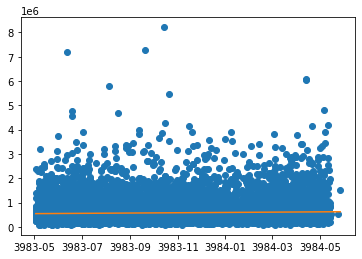

In [70]:
# on trace la régréssion linéaire entre le prix et la date (ordinale)
(a,b)=np.polyfit(data["date"].map(dt.datetime.toordinal),data['price'],1)

# on affiche les coefficients de regression
print(a,b)

plt.plot_date(data["date"].map(dt.datetime.toordinal), data['price'], fmt='o', tz=None, xdate=True, ydate=False)
plt.plot(data["date"].map(dt.datetime.toordinal),data["date"].map(dt.datetime.toordinal)*a+b)

# Étude des corrélations entre features et price



In [71]:
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]


Value
sqft_living vs price      0.697072
grade vs price            0.662982
sqft_above vs price       0.601451
sqft_living15 vs price    0.581688
bathrooms vs price        0.521281
view vs price             0.395809
sqft_basement vs price    0.321219
bedrooms vs price         0.306284
lat vs price              0.305024
waterfront vs price       0.265865
floors vs price           0.254501
yr_renovated vs price     0.123660
sqft_lot vs price         0.090412
sqft_lot15 vs price       0.082867
coef_ajustement vs price  0.057030
yr_built vs price         0.054062
zipcode vs price         -0.052739
condition vs price        0.032827
long vs price             0.020942

Fonctions utiles pour affichage et extraction 

In [110]:
# on va tester notre modèle sur chaque mois à partir du start_date
def display_res(func, start_date,end_date):
  r2_tab=[]
  rmse_tab=[]
  date_tab=[]
  for beg in pd.date_range(start_date, end_date, freq='MS'):
      # on lisse notre résultat sur 2 mois glissants
      start = pd.to_datetime(beg)-relativedelta(months=1)
      end = beg + MonthEnd(1)
      (x,Y) = extract_interval(start,end)
      print(start.strftime("%Y-%m-%d"),"-->",end.strftime("%Y-%m-%d"),'nbr_pred',len(Y))
      predicted_prices = func.predict(x)
      (rmse,mae,r2) = eval_metrics(Y,predicted_prices)
      r2_tab.append(r2)
      rmse_tab.append(rmse)
      date_tab.append(beg.strftime("%Y-%m-%d"))
      print("  RMSE: %s" % rmse)
      print("  MAE: %s" % mae)
      print("  R2: %s" % r2)
      print()   
  
  # affichage graphique
  fig, ax = plt.subplots(figsize = (10, 5))
  # titre du graphique 
  plt.title('evolution des metrics en fonction du temps')  
  
  # using the twinx() for creating another
  # axes object for secondry y-Axis
  ax2 = ax.twinx()
  ax.plot(date_tab, r2_tab, color = 'g',label="RMSE")
  ax2.plot(date_tab, rmse_tab, color = 'b',label="R2")
    
  ax.set_xlabel('Date')
  ax2.set_ylabel('RSME', color = "g")
  ax.set_ylabel('R2', color = 'b')
  # defining display layout 
  fig.legend()
  plt.show()

In [73]:
# fonction qui nous renvoit un x (6features) et un Y(price) à partir du dataset ajusté sur un interval entre deux dates
def extract_interval(start_date,end_date):
    try:
        # on filtre sur notre interval de date
        mask = (data['date'] >= start_date) & (data['date'] <= end_date)
        data_prep = data.loc[mask]
    
    except Exception as ex:
        print(ex)
        raise print("mauvais format de dates, attendu AAAA-MM-JJ")
    #x= data_prep[['sqft_living','grade','bathrooms','bedrooms','yr_built']]
    x= data_prep[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','lat','waterfront','bedrooms']]
    #x = data_prep.drop(['price','id','date','zipcode','lat','long','waterfront','sqft_basement','yr_renovated','view','sqft_lot','sqft_above','condition','sqft_living15','sqft_lot15','coef_ajustement'],axis=1)
    Y = data_prep['price']
    return x,Y

Création Random Forest

In [114]:
# on entraine puis test notre modèle sur les deux premiers mois 
start_date = '2014-05-01'
end_date = "2014-11-01"
x,Y = extract_interval(start_date,end_date)
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.20, random_state=42)

n_estimators=150
# on indique quelle expérience, nous voulons créer/utiliser
# mlflow.set_experiment("mon_expérience")
mlflow.set_experiment("pricing_prediction")

with mlflow.start_run():
   
    # enregistrer avec mlflow :
    #   - params
    #   - metrics
    #   - model
    #   - artifact(dataset de training)
    #   - tag (notes) : décrire sur quelle période le modèle a été entrainé

    # https://www.mlflow.org/docs/latest/python_api/mlflow.sklearn.html#mlflow.sklearn.log_model
    # exemple pour param et metrics
    # 
    # mlflow.log_param("param", exemple_param)
    # mlflow.log_metric("precision", exemple_predicision)

    # --------------------------------------
    #               corection 
    # --------------------------------------

    regRF = RandomForestRegressor(n_estimators=n_estimators)
    regRF.fit(x_train, y_train)

    predicted_prices = regRF.predict(x_test)
    (rmse,mae,r2) = eval_metrics(y_test,predicted_prices)
    print("model trained with date interval",start_date,'->',end_date)
    print("number of row trained",len(y_train))
    print("number of row tested",len(y_test),"\n")
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    #log param and metrics
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    #log artifact
    x_train.loc[:,'price']=y_train.values
    x_train.to_csv(tempfile.gettempdir()+'/training_dataset.csv')
    mlflow.log_artifact(tempfile.gettempdir()+'/training_dataset.csv')

    #set tag
    mlflow.set_tag("mlflow.note.content","Random Forest\nTraining period from "+start_date+" to "+end_date)

    #log model
    mlflow.sklearn.log_model(regRF, "model")

    mlflow.end_run()


model trained with date interval 2014-05-01 -> 2014-11-01
number of row trained 9404
number of row tested 2352 

  RMSE: 177640.1756267933
  MAE: 95336.58820499944
  R2: 0.7989899010527253
/Users/martincudicio/opt/anaconda3/envs/env_modeling/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/martincudicio/opt/anaconda3/envs/env_modeling/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

2014-10-01 --> 2014-11-30 nbr_pred 3289
  RMSE: 139765.74300692382
  MAE: 67714.65566286516
  R2: 0.882974506015902

2014-11-01 --> 2014-12-31 nbr_pred 2882
  RMSE: 169230.9053297564
  MAE: 94480.4089677541
  R2: 0.8064512960081283

2014-12-01 --> 2015-01-31 nbr_pred 2449
  RMSE: 171279.42218327505
  MAE: 98119.38327966817
  R2: 0.8095485688769554

2015-01-01 --> 2015-02-28 nbr_pred 2228
  RMSE: 187835.29801039485
  MAE: 104149.68659379923
  R2: 0.7570166848338498

2015-02-01 --> 2015-03-31 nbr_pred 3125
  RMSE: 193036.69400232684
  MAE: 113068.59185046659
  R2: 0.7496501199630479

2015-03-01 --> 2015-04-30 nbr_pred 4106
  RMSE: 211872.03119982587
  MAE: 124336.37986301615
  R2: 0.7345370206278183

2015-04-01 --> 2015-05-31 nbr_pred 2877
  RMSE: 236312.0540361922
  MAE: 133830.3869334984
  R2: 0.7026263285584244



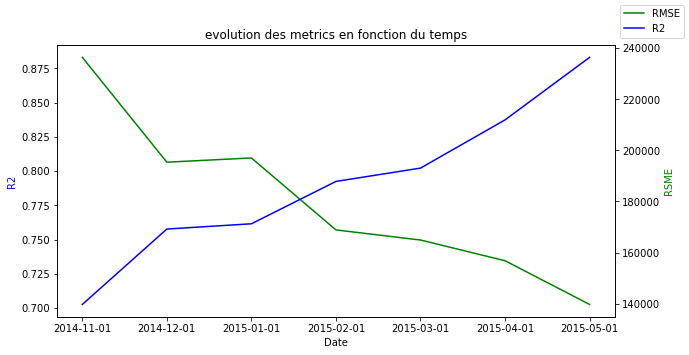

In [111]:
display_res(regRF,"2014-11","2015-05")

Création modèle XGboost, non fonctionnel en local si pas d'import de certains packages sur machine


In [17]:
import xgboost

# création model xgboost
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=7)
xgb.fit(x_train,y_train)

predicted_prices = xgb.predict(x_test)
(rmse,mae,r2) = eval_metrics(y_test,predicted_prices)
print("model trained with date interval",start_date,'->',end_date)
print("number of row trained",len(y_train))
print("number of row tested",len(y_test),"\n")
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/martincudicio/opt/anaconda3/envs/env_modeling/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/martincudicio/opt/anaconda3/envs/env_modeling/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


In [199]:
display_res(xgb,"2014-11","2015-5")

2014-10-01 --> 2014-11-30 nbr_pred 3289
  RMSE: 191537.84291729514
  MAE: 96851.96208888783
  R2: 0.789738827546394

2014-11-01 --> 2014-12-31 nbr_pred 2882
  RMSE: 175228.39489683296
  MAE: 97227.79280582341
  R2: 0.8029832908519549

2014-12-01 --> 2015-01-31 nbr_pred 2449
  RMSE: 176518.58261574132
  MAE: 102013.99198974785
  R2: 0.8089791064804637

2015-01-01 --> 2015-02-28 nbr_pred 2228
  RMSE: 189070.9584808371
  MAE: 107939.2075594076
  R2: 0.7689906756017078

2015-02-01 --> 2015-03-31 nbr_pred 3125
  RMSE: 203114.5312291357
  MAE: 120504.02460379784
  R2: 0.7417953919743834

2015-03-01 --> 2015-04-30 nbr_pred 4106
  RMSE: 223541.65637547418
  MAE: 135839.82447851155
  R2: 0.7262159282622206

2015-04-01 --> 2015-05-31 nbr_pred 2877
  RMSE: 243321.93546958143
  MAE: 146280.6707536044
  R2: 0.7089496288475957

